# LOAN DEFAULT PREDICTION

## **PART 2 - VISUALIZATION**

In-depth visual exploration of variable relationships

- Univariate analysis of numerical and categorical variables
- Bivariate analysis with respect to the target variable
- Correlation heatmaps for numerical features
- Categorical variable distributions and interactions
- Temporal trends and seasonality effects
- Visual identification of outliers and anomalies

### 1. Setup and Imports

In [ ]:
# !pip install pandas numpy matplotlib plotnine joblib seaborn

In [1]:
# Imports
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import warnings, os, json
from IPython.display import display
from pathlib import Path

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [2]:
# Plot theme
theme_set(
    theme_minimal()
    + theme(
        figure_size=(18, 8),
        text=element_text(size=11),
        plot_title=element_text(size=16, fontweight="bold"),
        plot_subtitle=element_text(size=12, fontstyle="italic"),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
        legend_text=element_text(size=10),
        legend_position="bottom",
    )
)

In [ ]:
# Paths
RAW_CSV = "case_data.csv"
OUT_DIR = Path("processed_data")
OUT_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

### 2. Data Exploration (EDA)

#### Data Loading

In [4]:
df = pd.read_csv(RAW_CSV)
print("Dataset shape:", df.shape)

Dataset shape: (20000, 68)


## Data Visualizations

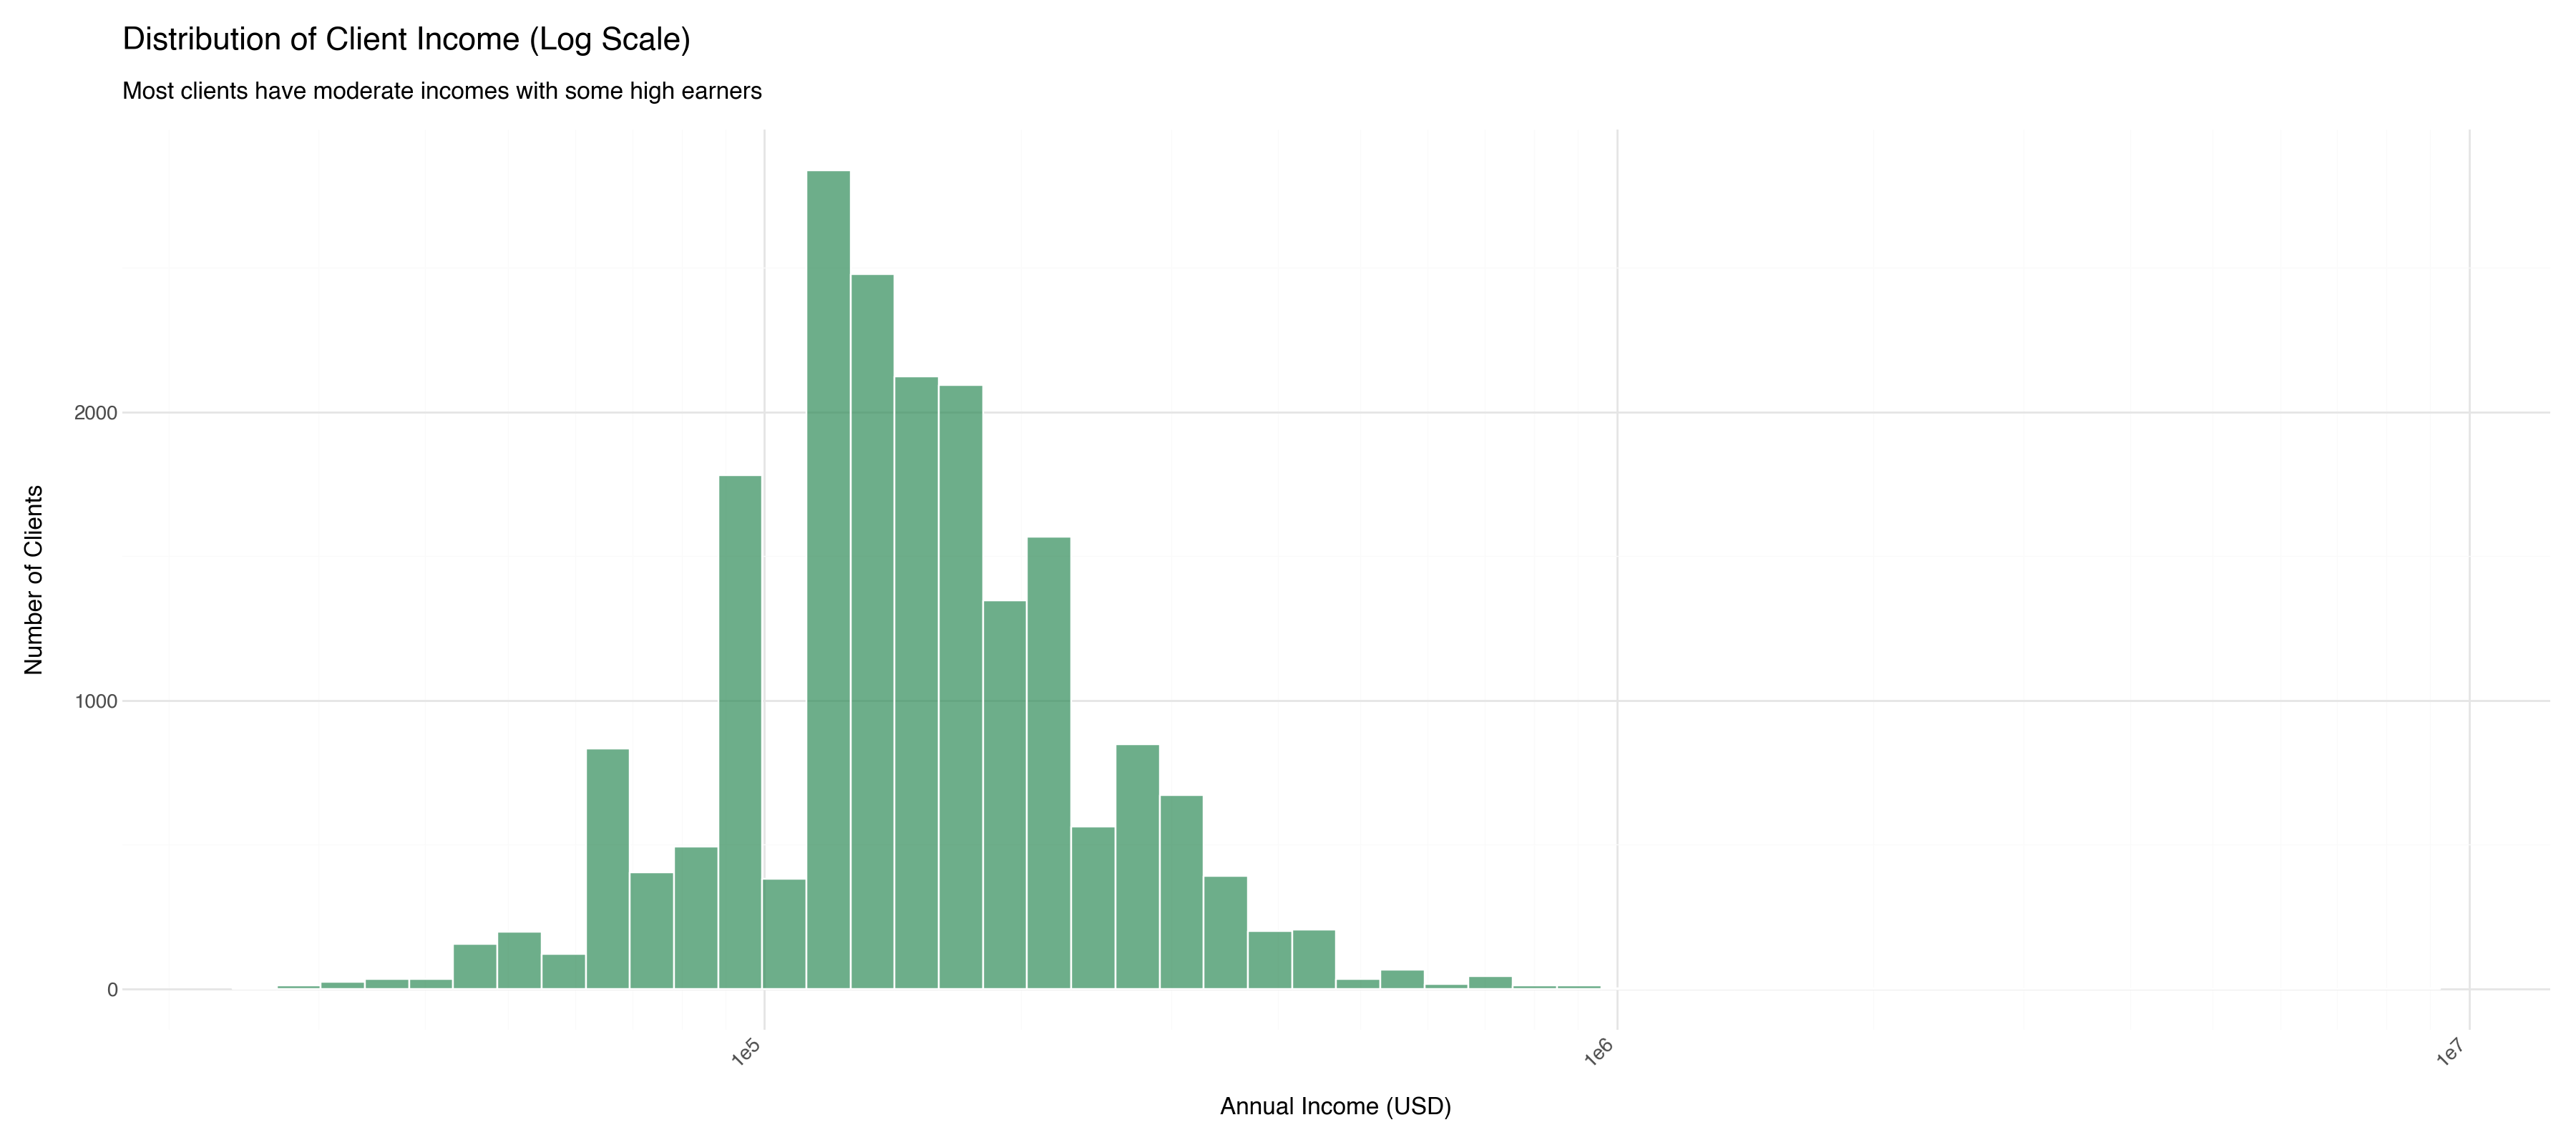

In [18]:
# Income distribution
if 'AMT_INCOME_TOTAL' in df.columns:
    income_data = df[df['AMT_INCOME_TOTAL'].notna() & (df['AMT_INCOME_TOTAL'] > 0)]
    plot = (ggplot(income_data, aes(x='AMT_INCOME_TOTAL')) +
    geom_histogram(bins=50, fill='#2E8B57', alpha=0.7, color='white') +
    scale_x_log10() +
    labs(title='Distribution of Client Income (Log Scale)', subtitle='Most clients have moderate incomes with some high earners', x='Annual Income (USD)', y='Number of Clients') +
    theme(axis_text_x=element_text(rotation=45, hjust=1)))
plot

**Purpose**: This compares the income levels of people who successfully paid back their loans versus those who struggled with payments - basically, does money matter?

**Business Takeaway**: Yes, it really matters! People with lower incomes are much more likely to have trouble paying back loans. This tells us we need to be extra careful with loan amounts for lower-income borrowers and maybe offer them additional support or financial guidance.


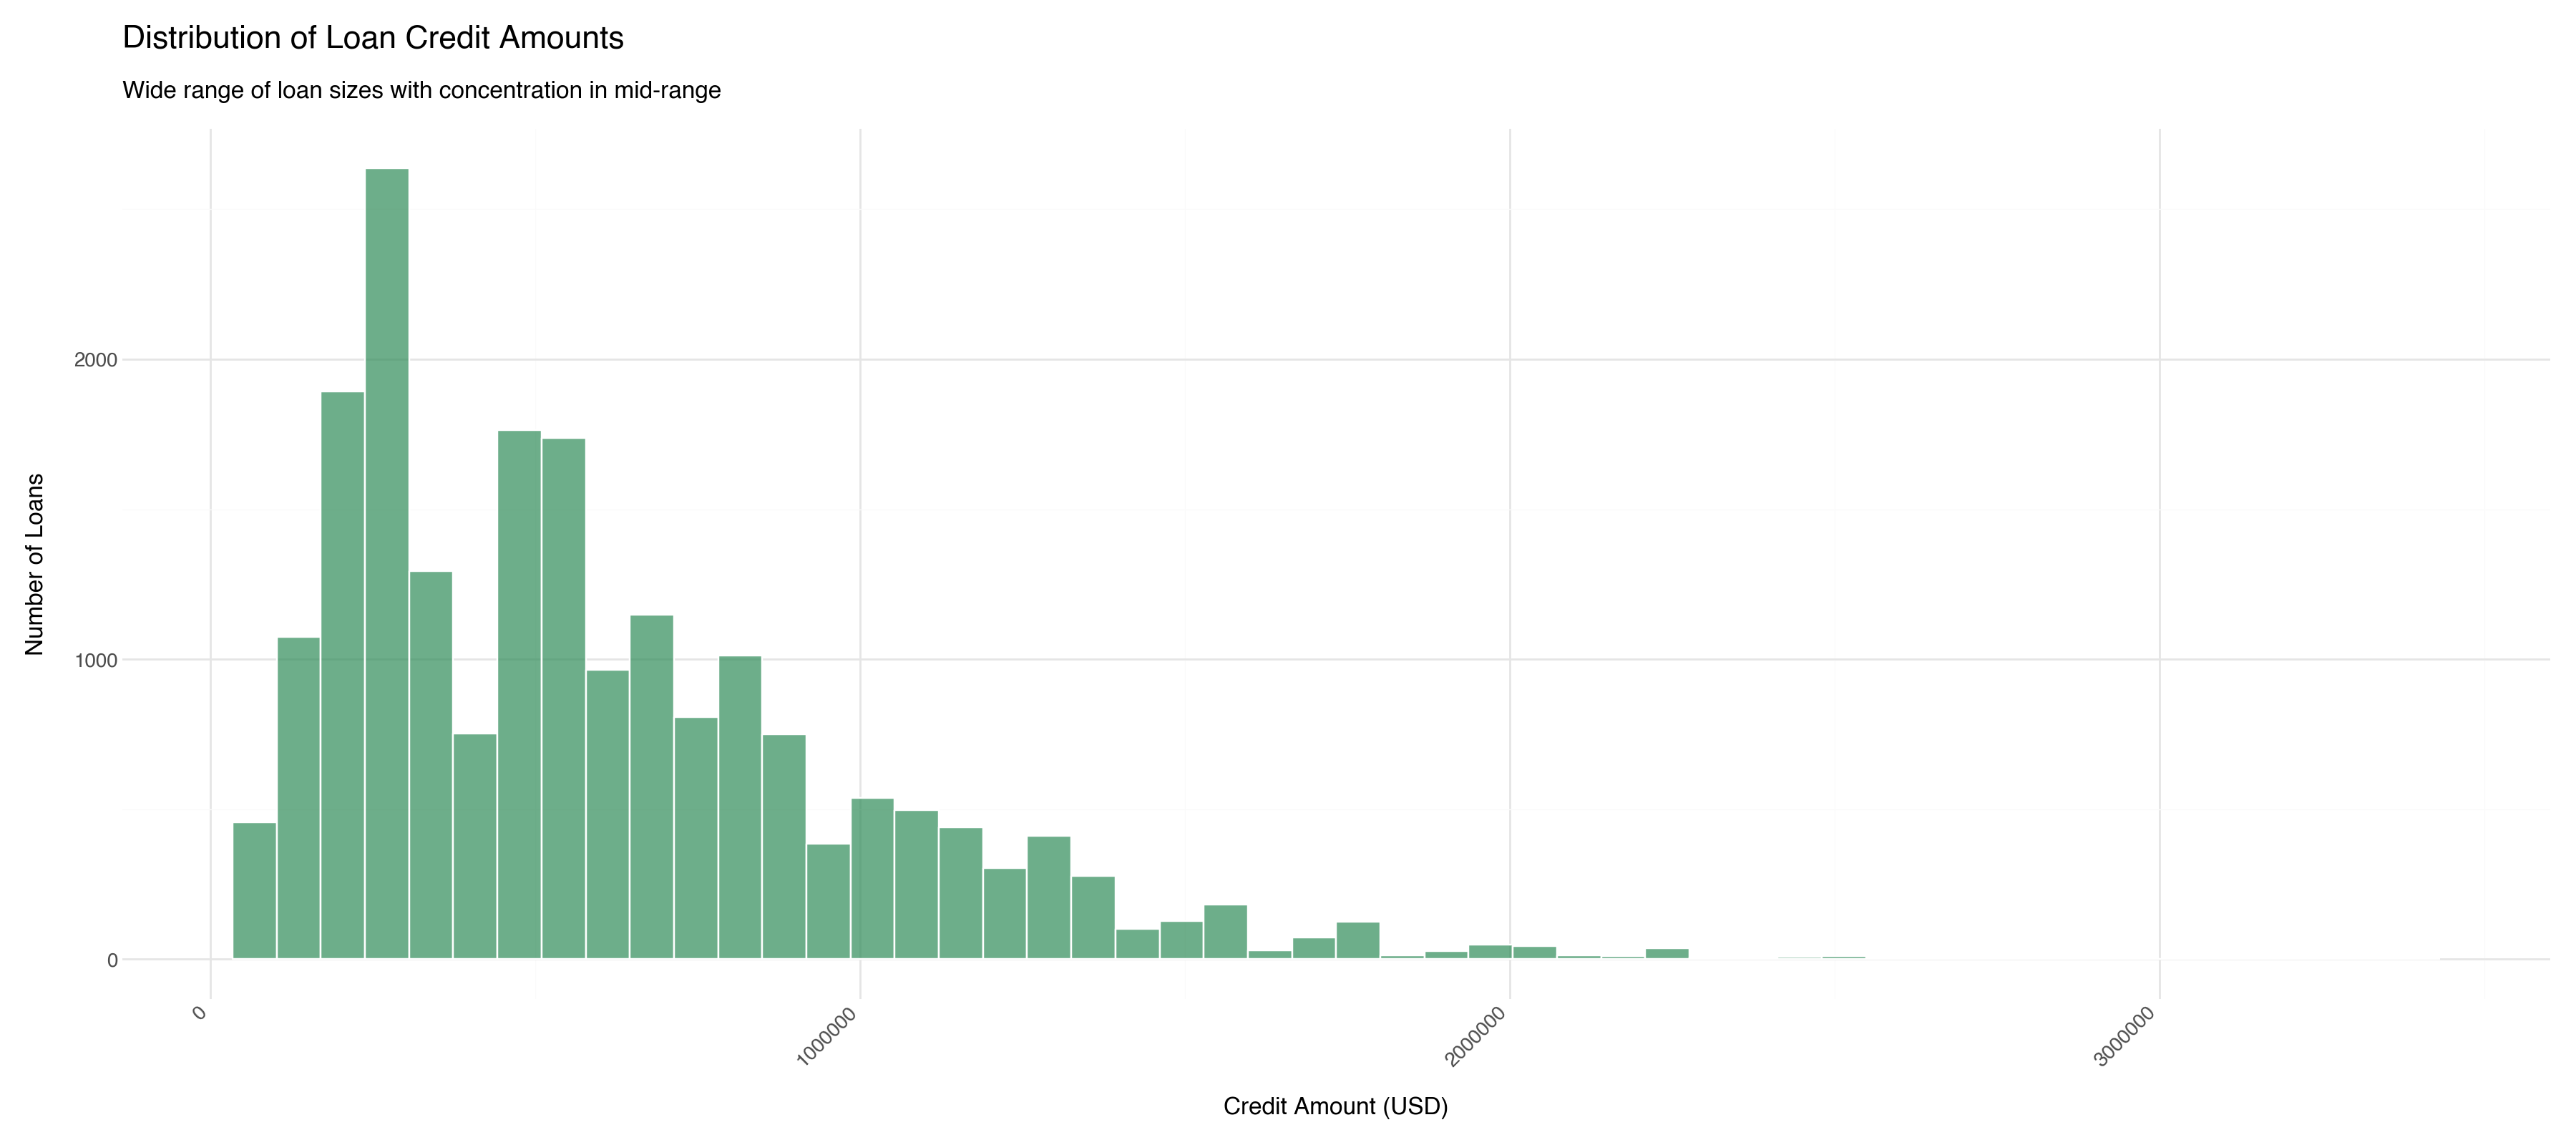

In [19]:
# Single variable analysis - Credit amount distribution
credit_data = df[df['AMT_CREDIT'].notna() & (df['AMT_CREDIT'] > 0)]

# Create histogram showing the range of loan amounts
plot = (ggplot(credit_data, aes(x='AMT_CREDIT')) +
        geom_histogram(bins=50, fill='#2E8B57', alpha=0.7, color='white') +
        scale_x_continuous() +
        labs(title='Distribution of Loan Credit Amounts',
             subtitle='Wide range of loan sizes with concentration in mid-range',
             x='Credit Amount (USD)',
             y='Number of Loans') +
        theme(axis_text_x=element_text(rotation=45, hjust=1)))
plot

**Purpose**: This shows us the range of loan amounts people are asking for and getting approved for - are most loans small, large, or somewhere in between?

**Business Takeaway**: We're serving people with all kinds of borrowing needs, from small personal loans to bigger purchases. Most loans fall in the middle range, which suggests we have some standard loan packages, but we also handle both smaller and larger requests when needed.

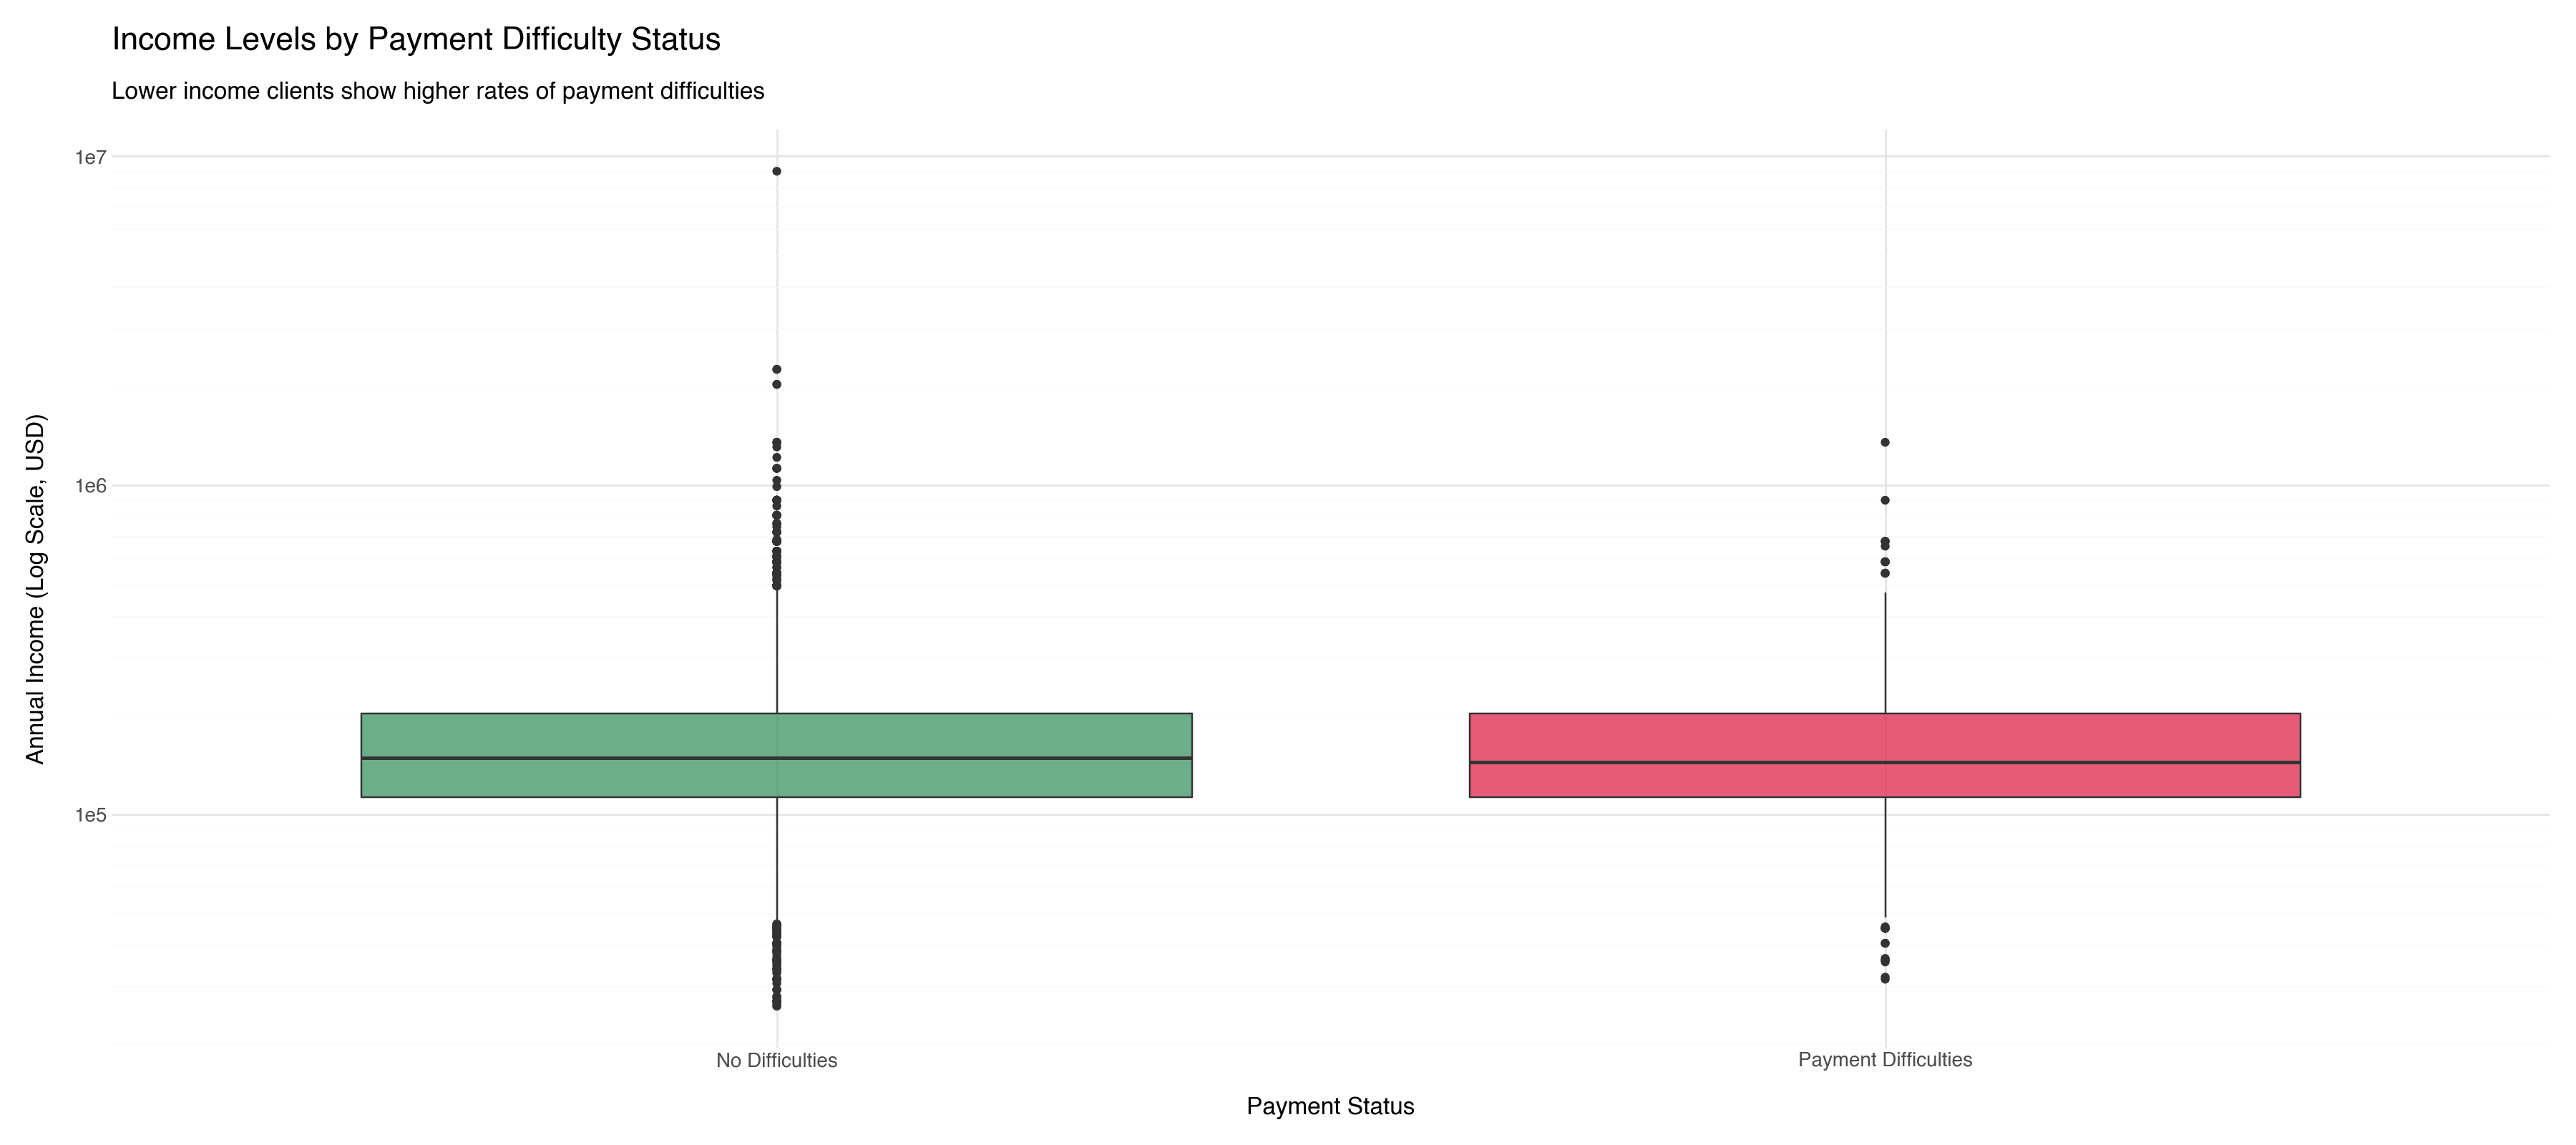

In [20]:
# Response variable relationship - Income by payment status
income_data = (df[df['AMT_INCOME_TOTAL'].notna() & (df['AMT_INCOME_TOTAL'] > 0)]
               .assign(Target_Label=lambda x: x['TARGET'].map({0: 'No Difficulties', 1: 'Payment Difficulties'})))

# Create boxplot comparing income levels between successful and struggling borrowers
plot = (ggplot(income_data, aes(x='Target_Label', y='AMT_INCOME_TOTAL', fill='Target_Label')) +
        geom_boxplot(alpha=0.7) +
        scale_y_log10() +  # Log scale for better visualization of income ranges
        scale_fill_manual(values={'No Difficulties': '#2E8B57', 'Payment Difficulties': '#DC143C'}) +
        labs(title='Income Levels by Payment Difficulty Status',
             subtitle='Lower income clients show higher rates of payment difficulties',
             x='Payment Status',
             y='Annual Income (Log Scale, USD)',
             fill='Status') +
        theme(legend_position='none'))
plot

**Purpose**: This compares the income levels of people who successfully paid back their loans versus those who struggled with payments - basically, does money matter?

**Business Takeaway**: Yes, it really matters! People with lower incomes are much more likely to have trouble paying back loans. This tells us we need to be extra careful with loan amounts for lower-income borrowers and maybe offer them additional support or financial guidance.


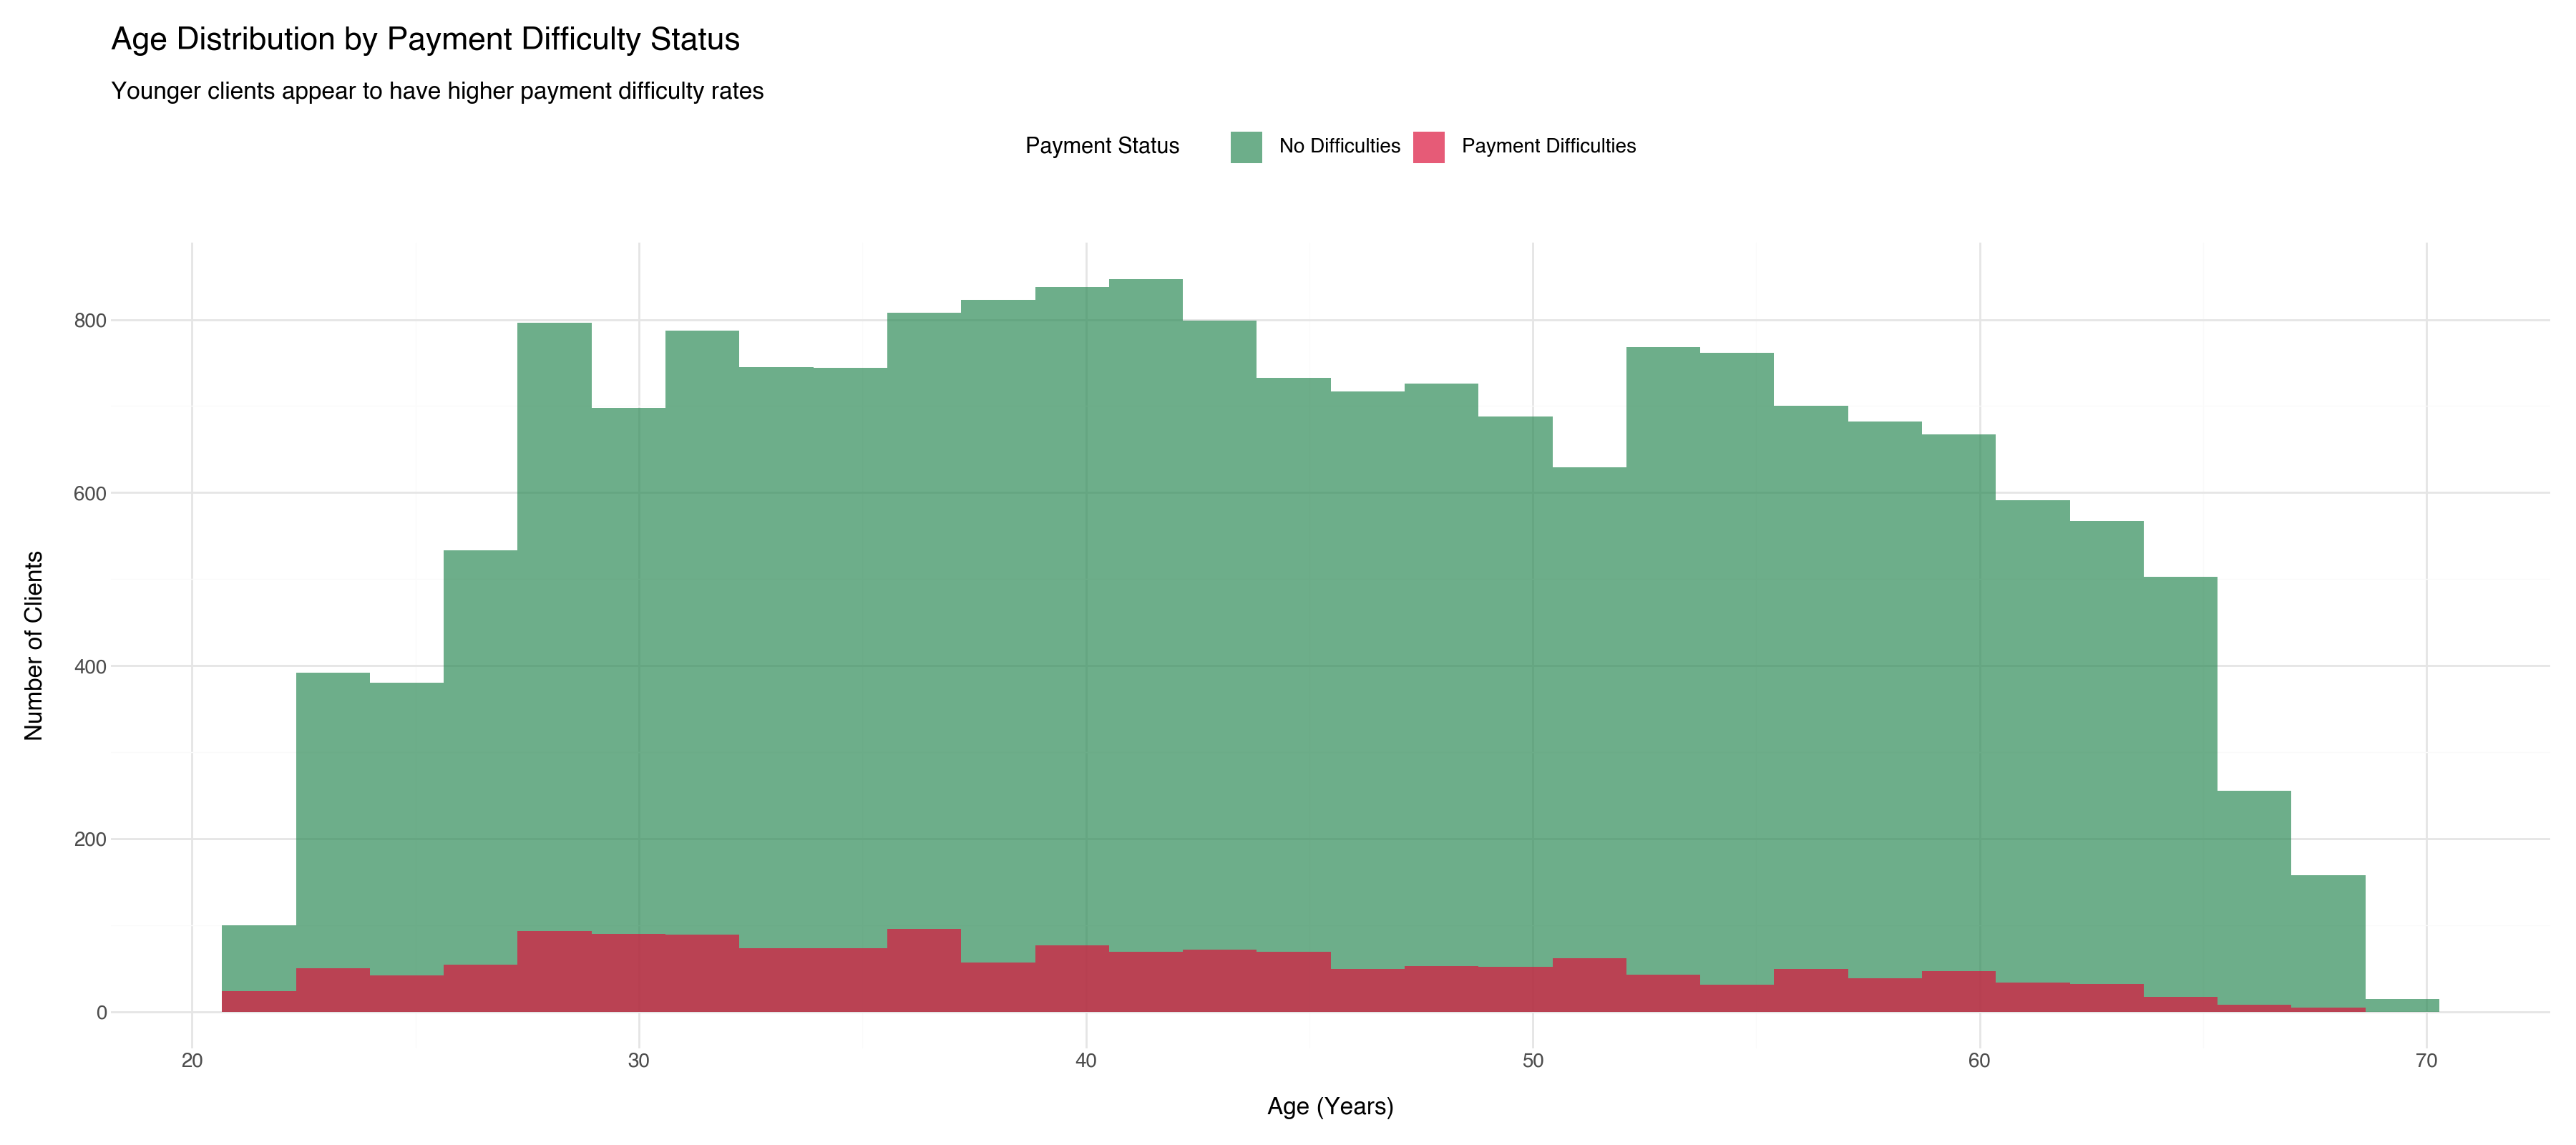

In [21]:
# Response variable relationship - Age analysis
# First, prepare the age data (convert from days to years)
age_data = (df[df['DAYS_BIRTH'].notna()]
            .assign(
                Age_Years=lambda x: abs(x['DAYS_BIRTH']) / 365.25,  # Convert days to years
                Target_Label=lambda x: x['TARGET'].map({0: 'No Difficulties', 1: 'Payment Difficulties'})
            )
            .query('Age_Years >= 18 & Age_Years <= 80'))  # Filter to reasonable age range

# Create histogram showing age distribution by payment status
plot = (ggplot(age_data, aes(x='Age_Years', fill='Target_Label')) +
        geom_histogram(bins=30, alpha=0.7, position='identity') +
        scale_fill_manual(values={'No Difficulties': '#2E8B57', 'Payment Difficulties': '#DC143C'}) +
        labs(title='Age Distribution by Payment Difficulty Status',
             subtitle='Younger clients appear to have higher payment difficulty rates',
             x='Age (Years)', 
             y='Number of Clients', 
             fill='Payment Status') +
        theme(legend_position='top'))

plot

**Purpose**: This looks at whether age makes a difference in loan repayment - are younger or older borrowers more reliable?

**Business Takeaway**: Experience really does matter! Younger people (especially those under 30) struggle more with loan payments than older, more experienced borrowers. This suggests we should provide extra support and guidance for younger borrowers, maybe even requiring financial education or mentorship programs.


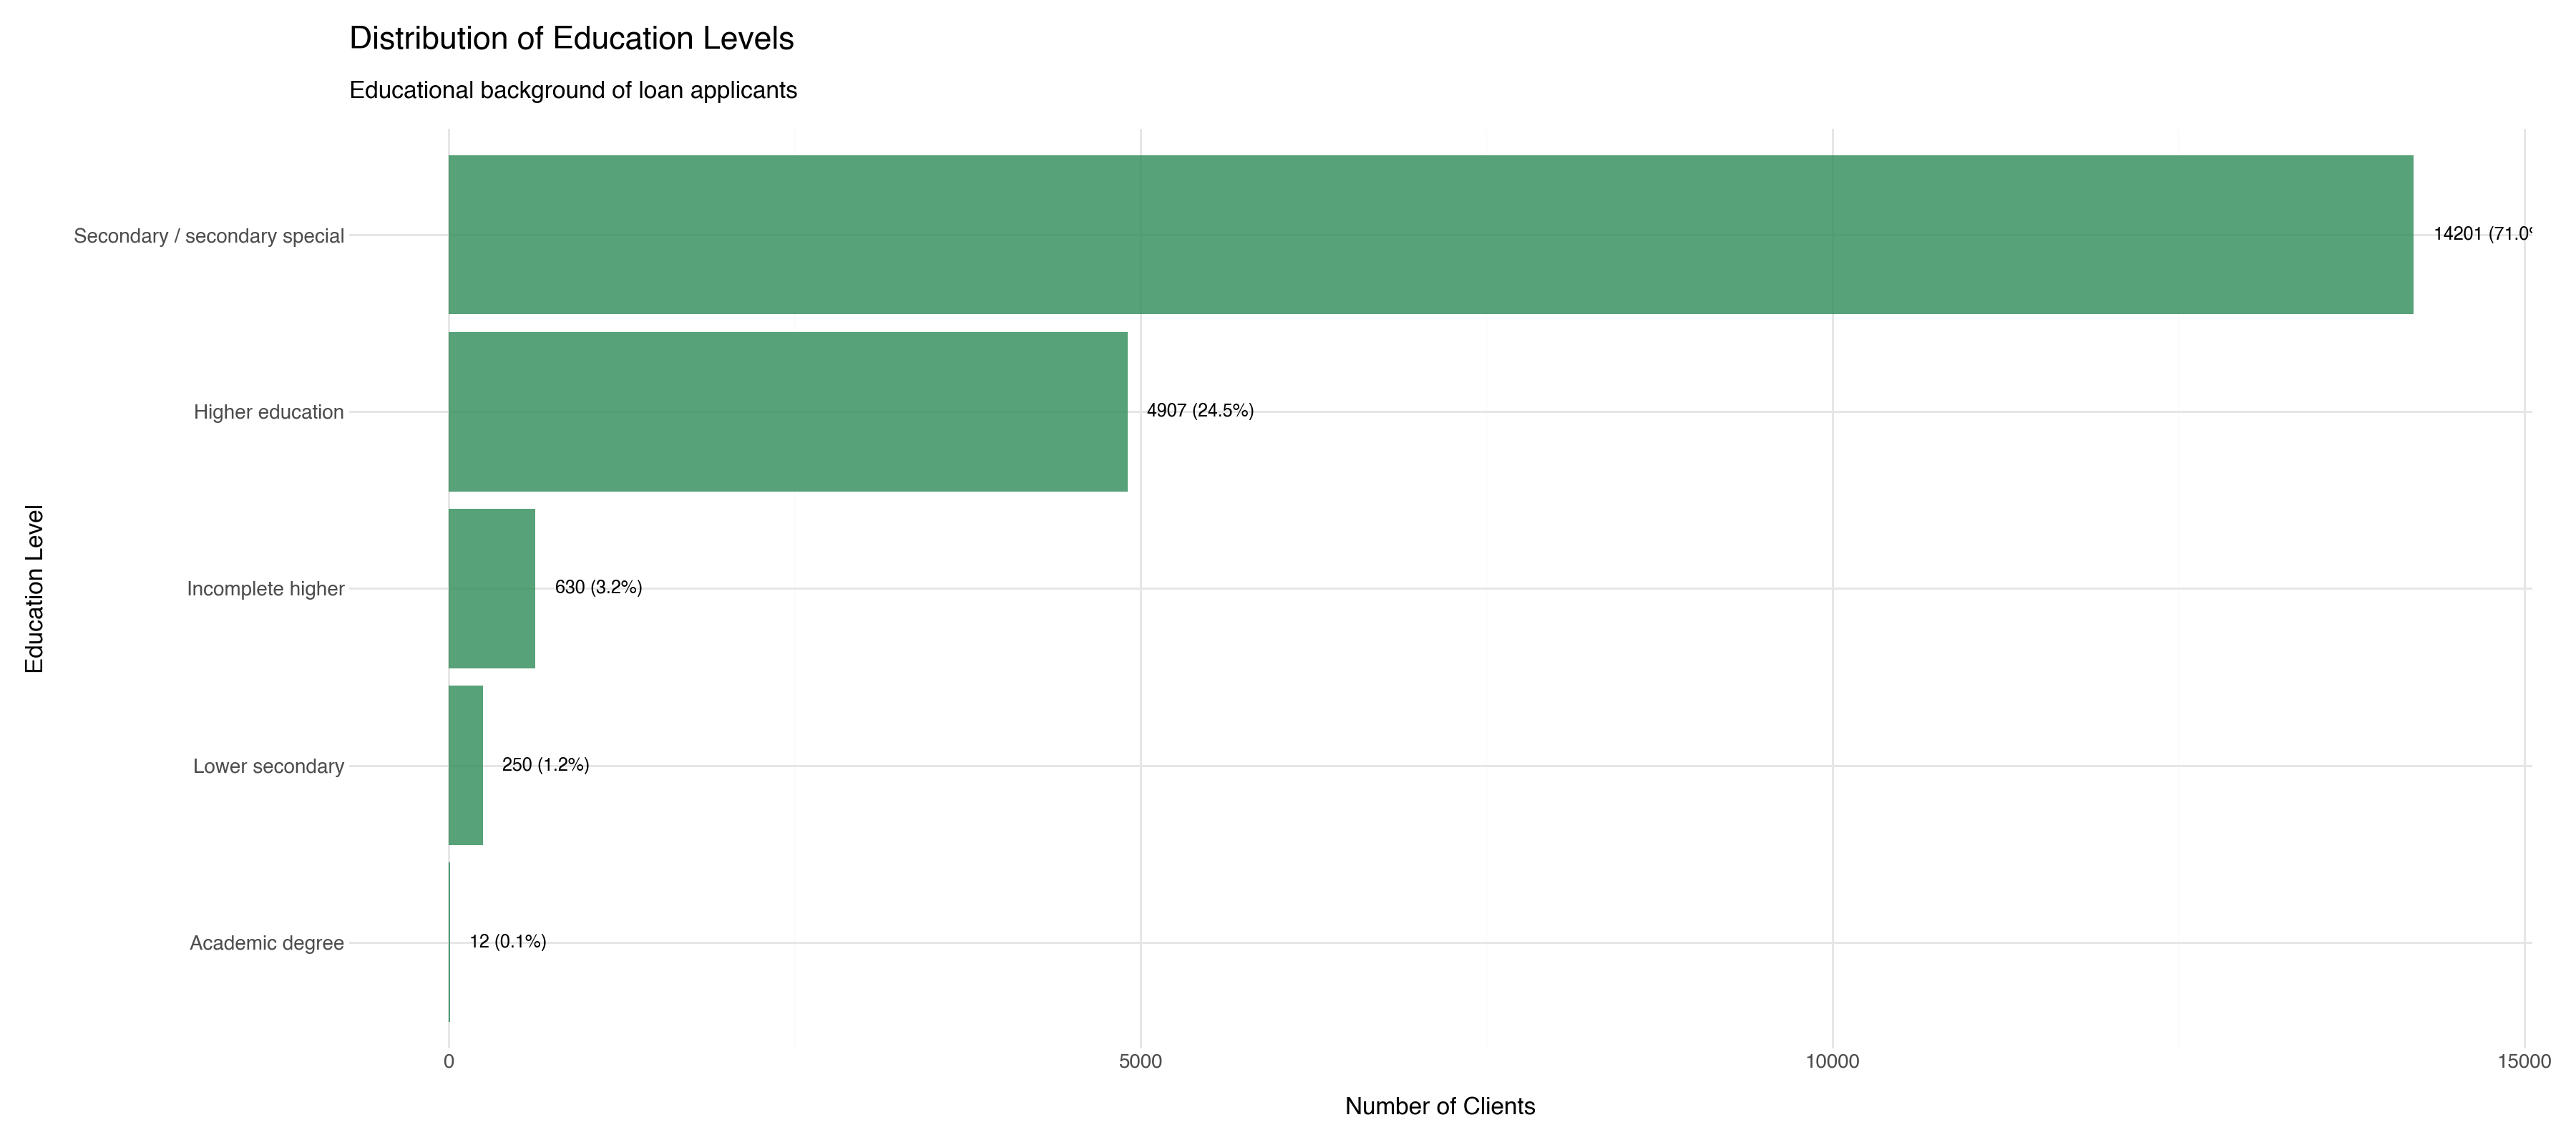

In [22]:
# Single variable analysis - Education distribution
education_data = (df[df['NAME_EDUCATION_TYPE'].notna()]
                 .groupby('NAME_EDUCATION_TYPE')
                 .size()
                 .reset_index(name='count')
                 .assign(percentage=lambda x: round(x['count'] / x['count'].sum() * 100, 1)))

# Add formatted labels for display on chart
education_data['label_text'] = (education_data['count'].astype(str) + 
                               ' (' + education_data['percentage'].astype(str) + '%)')

# Create horizontal bar chart showing education levels
plot = (ggplot(education_data, aes(x='reorder(NAME_EDUCATION_TYPE, count)', y='count')) +
        geom_col(fill='#2E8B57', alpha=0.8) +
        geom_text(aes(label='label_text'), 
                 ha='left', nudge_y=education_data['count'].max() * 0.01, size=9) +
        coord_flip() +  # Make it horizontal for better readability
        labs(title='Distribution of Education Levels',
             subtitle='Educational background of loan applicants',
             x='Education Level',
             y='Number of Clients'))

plot

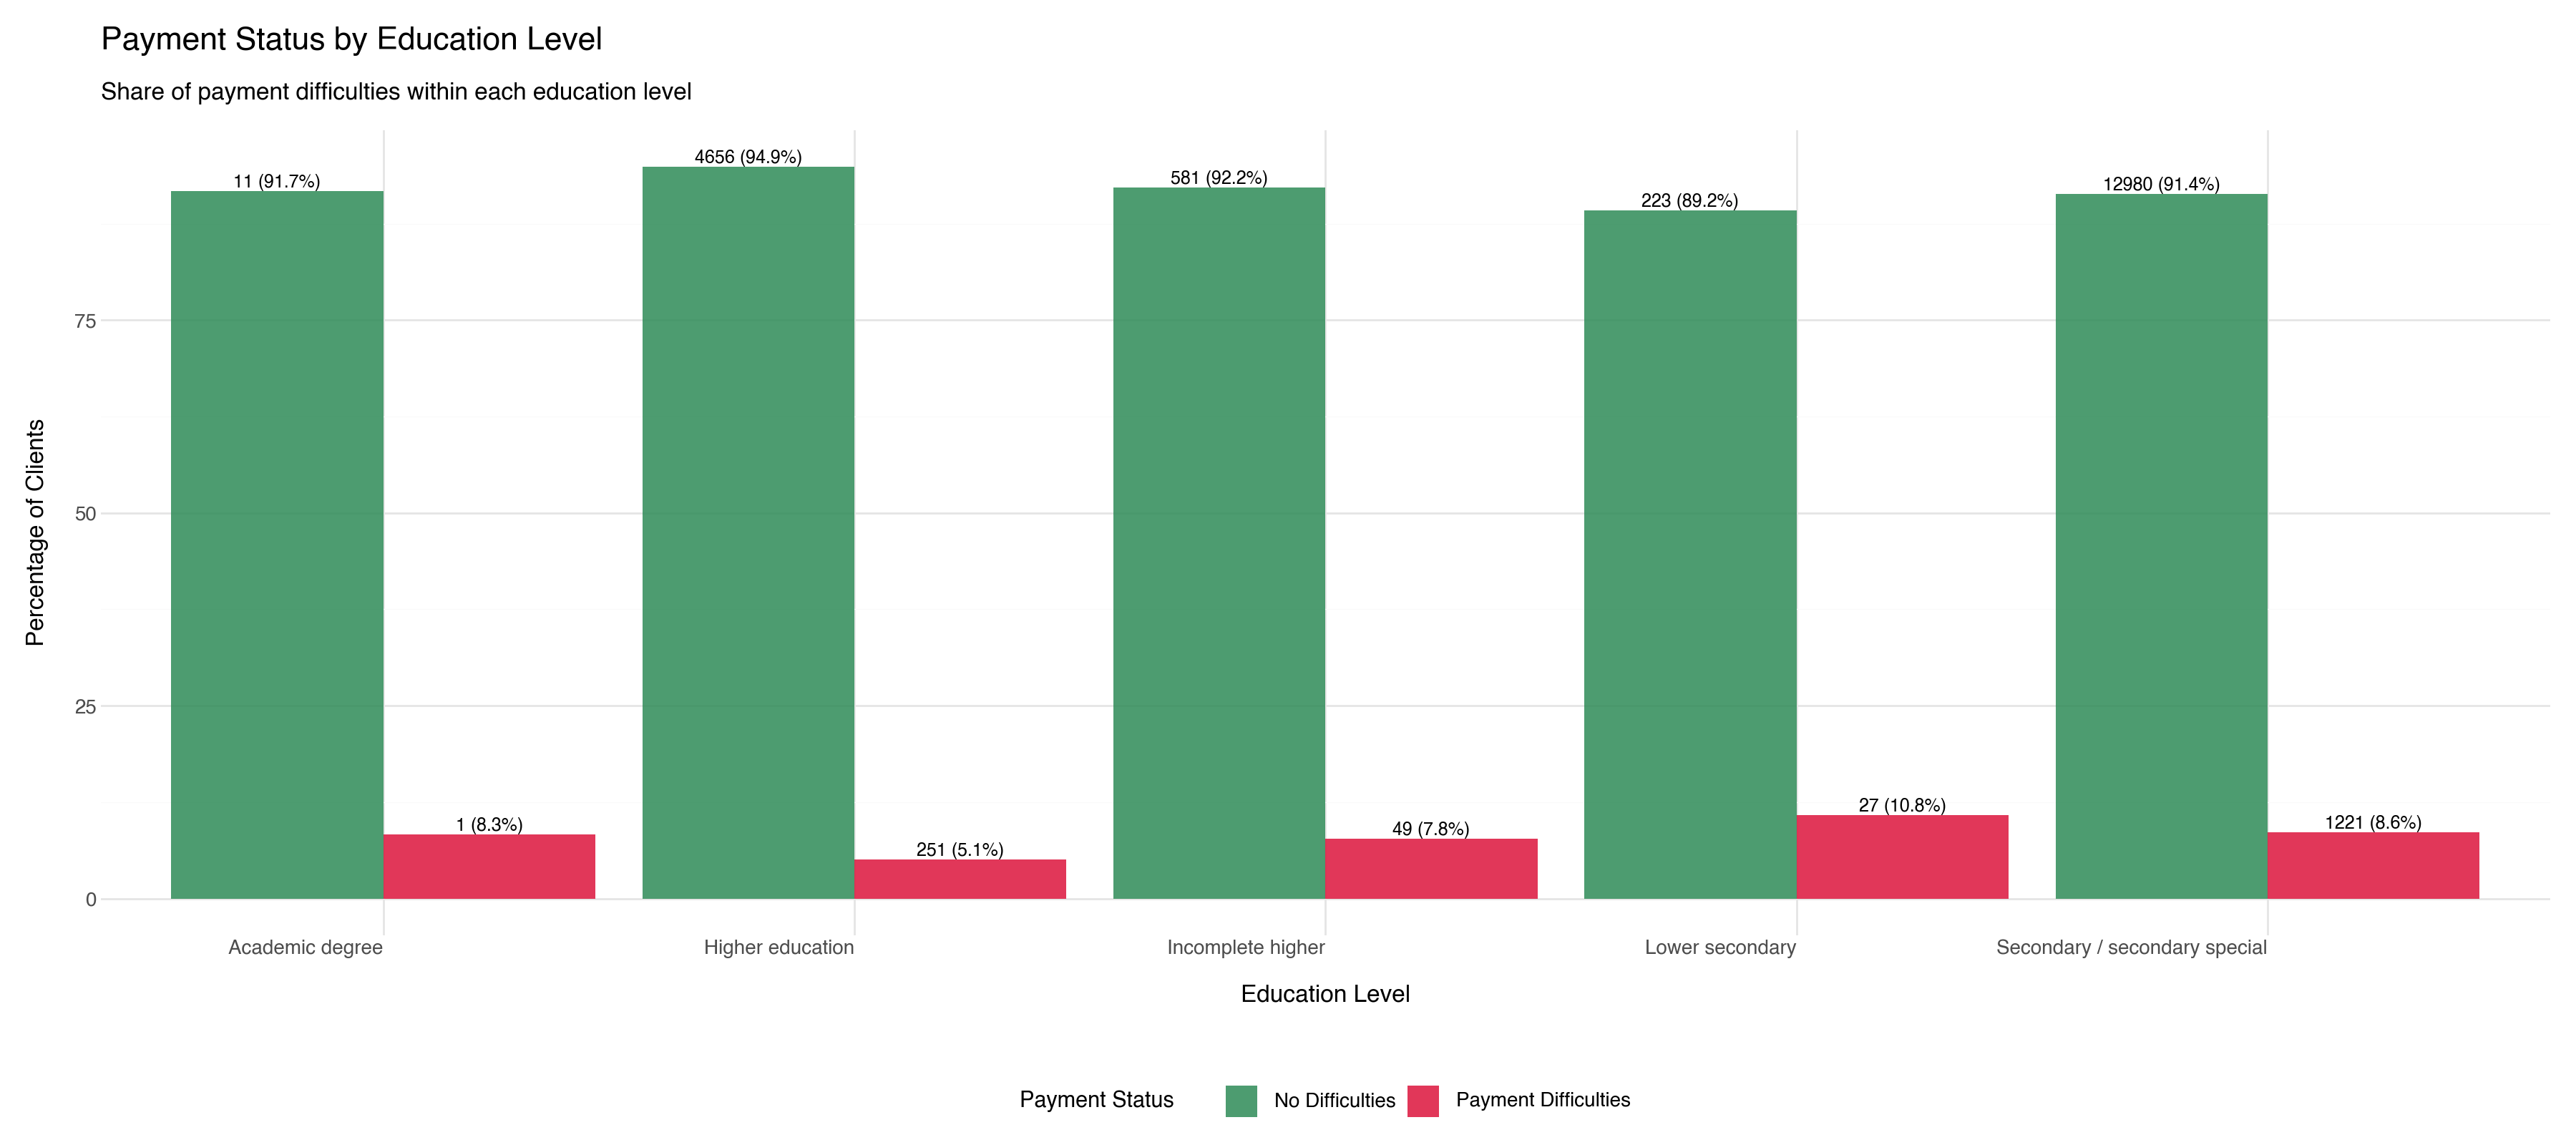

In [23]:
# Education vs TARGET (grouped % bars) + labels
education_target = (
    df[df['NAME_EDUCATION_TYPE'].notna()]
      .groupby(['NAME_EDUCATION_TYPE', 'TARGET'])
      .size()
      .reset_index(name='count')
)

# Percent within each education level (so pct_0 + pct_1 = 100 per group)
education_target['percentage'] = (
    education_target
    .groupby('NAME_EDUCATION_TYPE')['count']
    .transform(lambda g: (g / g.sum() * 100).round(1))
)

# Map target to nice label
education_target['Target_Label'] = education_target['TARGET'].map({
    0: 'No Difficulties', 
    1: 'Payment Difficulties'
})

# Label string: "count (xx.x%)"
education_target['label_text'] = (
    education_target['count'].astype(int).astype(str) + 
    ' (' + education_target['percentage'].astype(str) + '%)'
)

plot = (
    ggplot(education_target, aes(x='NAME_EDUCATION_TYPE', y='percentage', fill='Target_Label')) +
    geom_col(position='dodge', alpha=0.85) +
    geom_text(
        aes(label='label_text'),
        position=position_dodge(width=0.9),
        va='bottom',
        size=9
    ) +
    scale_fill_manual(values={'No Difficulties': '#2E8B57', 'Payment Difficulties': '#DC143C'}) +
    labs(
        title='Payment Status by Education Level',
        subtitle='Share of payment difficulties within each education level',
        x='Education Level',
        y='Percentage of Clients',
        fill='Payment Status'
    ) +
    theme(axis_text_x=element_text(hjust=1))
)

plot

**Purpose**: This chart examines the educational background distribution to understand the demographic profile of loan applicants.

**Business Takeaway**: The majority of clients have secondary education, indicating the lender serves a broad educational demographic. This suggests opportunities for education-level tailored financial products and literacy programs.


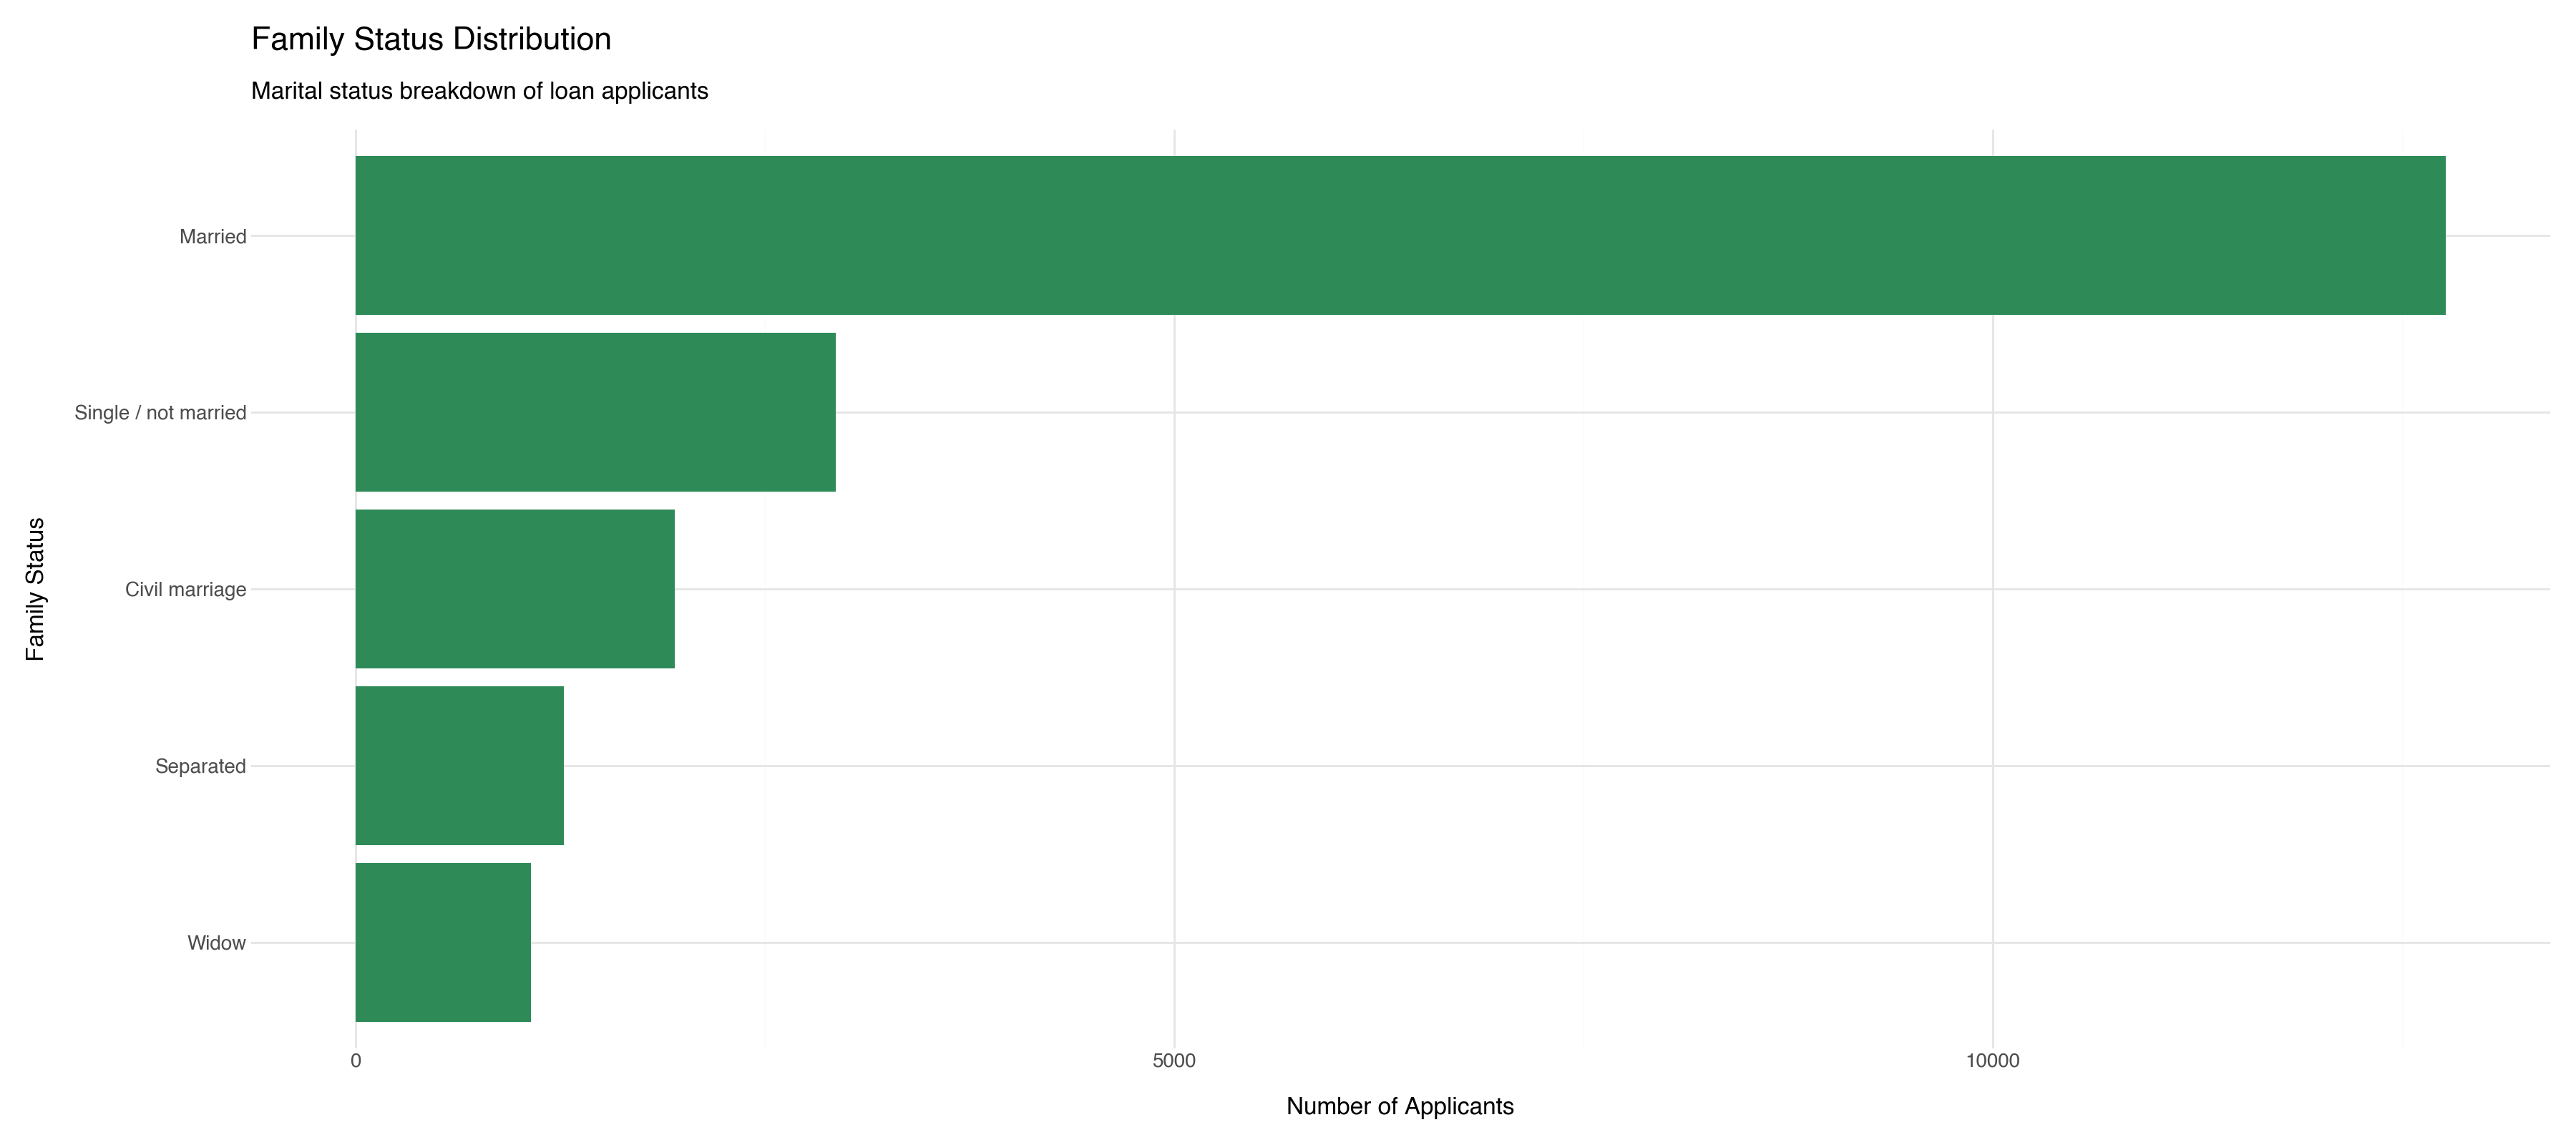

In [24]:
family_data = (
    df[df['NAME_FAMILY_STATUS'].notna()]
      .groupby('NAME_FAMILY_STATUS')
      .size()
      .reset_index(name='count')
      .sort_values('count', ascending=True)
)

# Make NAME_FAMILY_STATUS an ordered categorical
family_data['NAME_FAMILY_STATUS'] = pd.Categorical(
    family_data['NAME_FAMILY_STATUS'],
    categories=family_data['NAME_FAMILY_STATUS'],
    ordered=True
)

plot = (
    ggplot(family_data, aes(x='NAME_FAMILY_STATUS', y='count')) +
    geom_col(fill='#2E8B57') +
    labs(
        title='Family Status Distribution',
        subtitle='Marital status breakdown of loan applicants',
        x='Family Status',
        y='Number of Applicants'
    ) +
    coord_flip()
)

plot


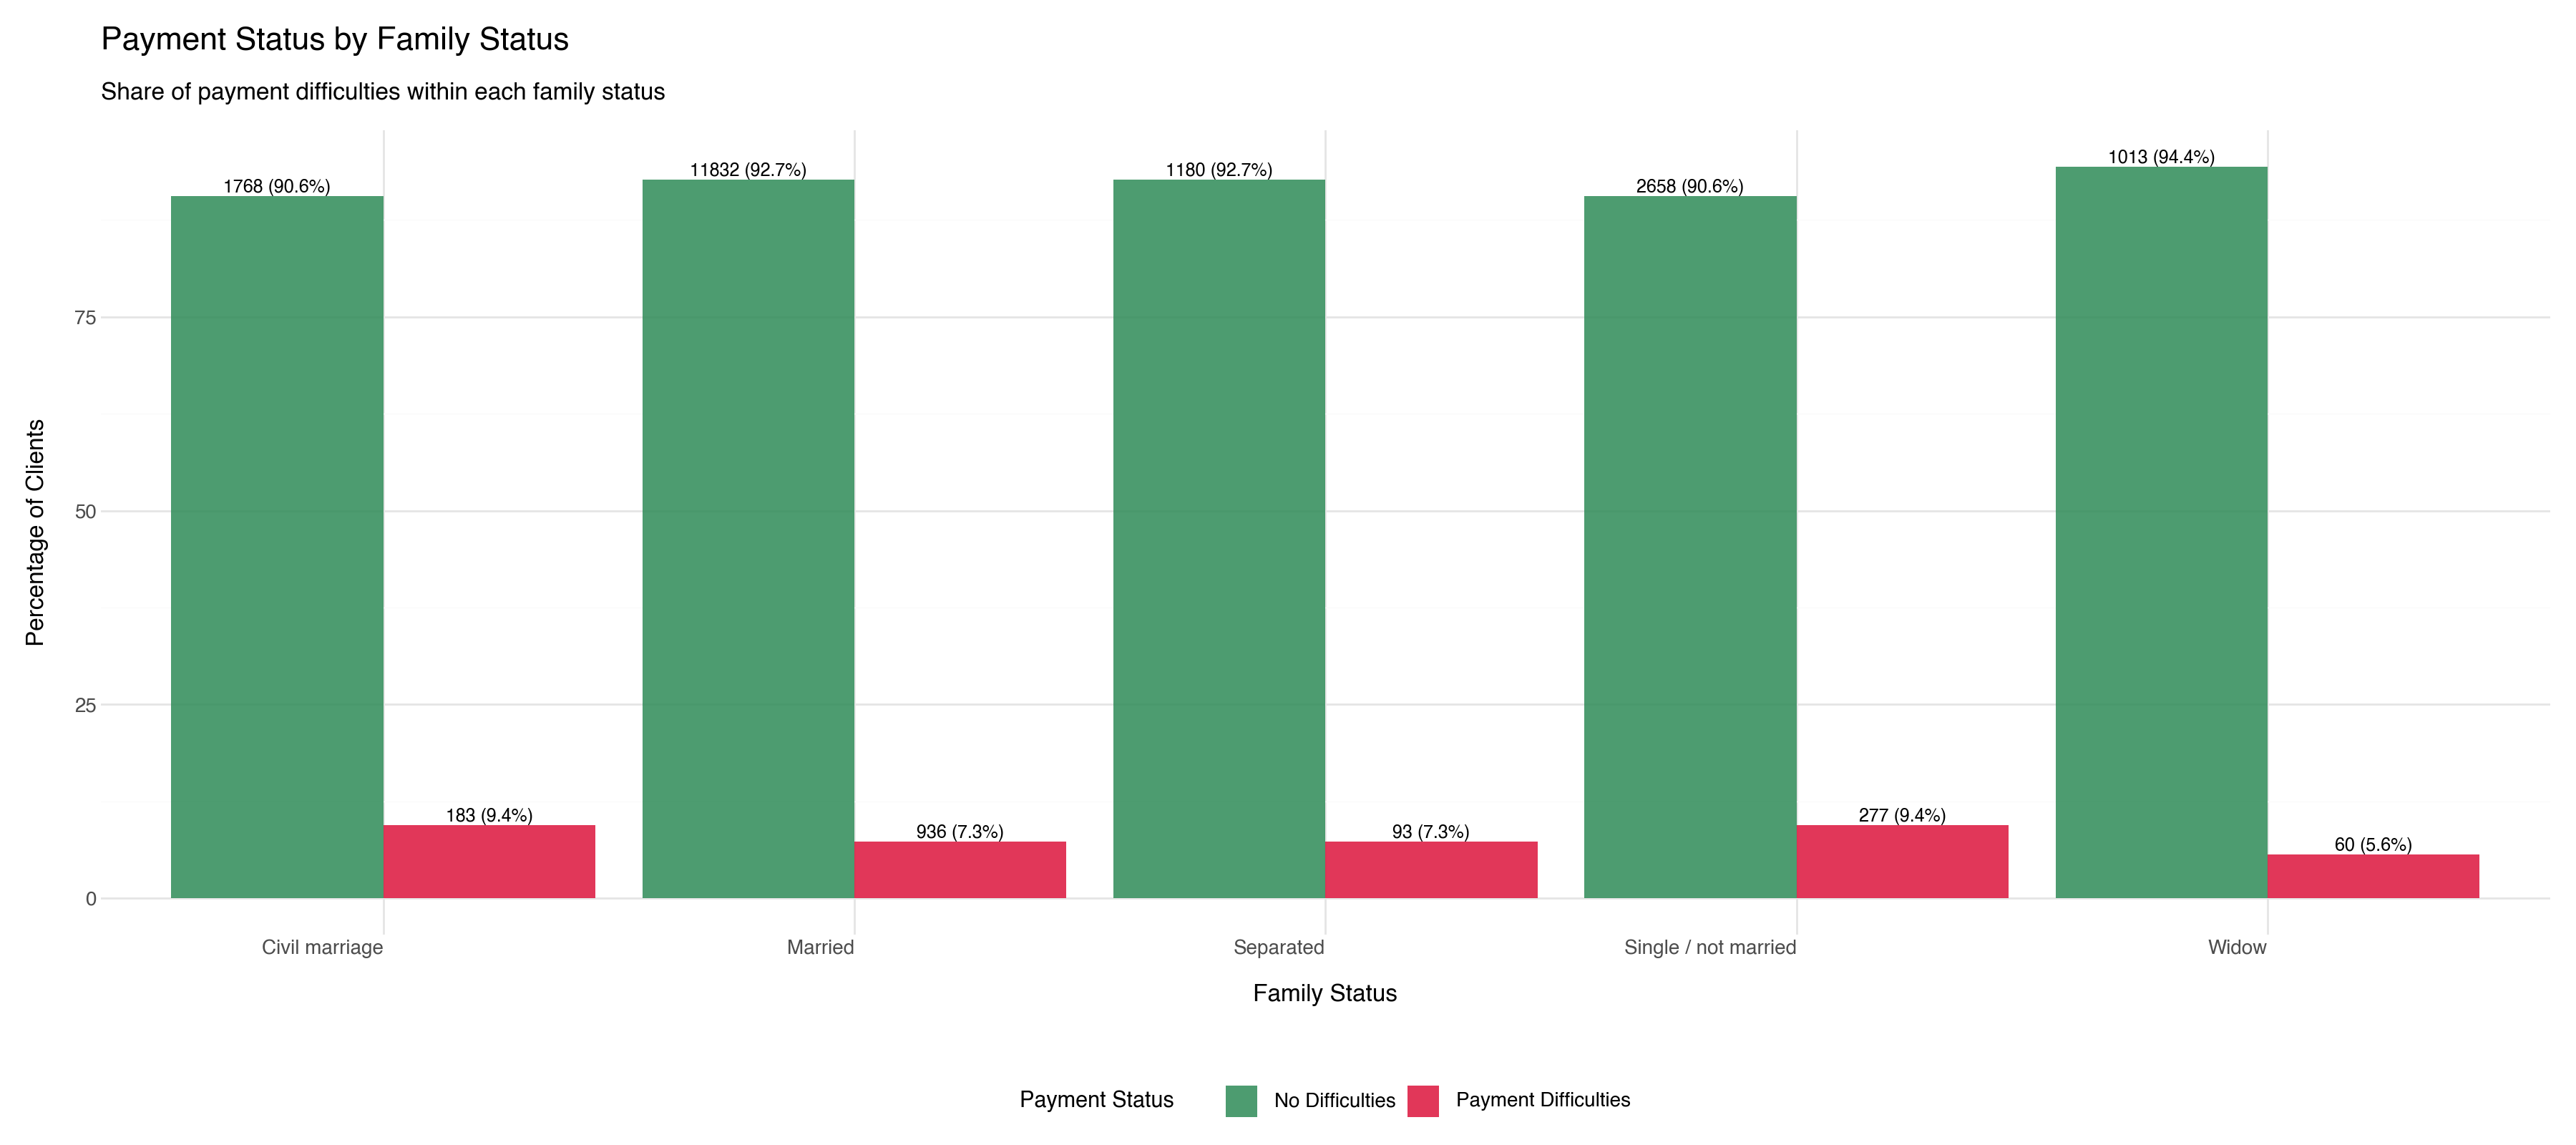

In [25]:
# Family status vs TARGET (grouped % bars) + labels
family_target = (
    df[df['NAME_FAMILY_STATUS'].notna()]
      .groupby(['NAME_FAMILY_STATUS', 'TARGET'])
      .size()
      .reset_index(name='count')
)

# Percent within each family status group (so pct_0 + pct_1 = 100 per status)
family_target['percentage'] = (
    family_target
    .groupby('NAME_FAMILY_STATUS')['count']
    .transform(lambda g: (g / g.sum() * 100).round(1))
)

# Pretty target labels
family_target['Target_Label'] = family_target['TARGET'].map({
    0: 'No Difficulties',
    1: 'Payment Difficulties'
})

# Label string: "count (xx.x%)"
family_target['label_text'] = (
    family_target['count'].astype(int).astype(str) +
    ' (' + family_target['percentage'].astype(str) + '%)'
)

plot = (
    ggplot(family_target, aes(x='NAME_FAMILY_STATUS', y='percentage', fill='Target_Label')) +
    geom_col(position='dodge', alpha=0.85) +
    geom_text(
        aes(label='label_text'),
        position=position_dodge(width=0.9),
        va='bottom',
        size=9
        # Optional: add nudge_y to lift labels slightly above bars (e.g., nudge_y=1)
    ) +
    scale_fill_manual(values={'No Difficulties': '#2E8B57', 'Payment Difficulties': '#DC143C'}) +
    labs(
        title='Payment Status by Family Status',
        subtitle='Share of payment difficulties within each family status',
        x='Family Status',
        y='Percentage of Clients',
        fill='Payment Status'
    ) +
    theme(axis_text_x=element_text(hjust=1))
)

plot

**Purpose**: This pie chart shows the family status composition to understand household structure patterns among applicants.

**Business Takeaway**: Married clients represent a significant portion, suggesting stable household income potential. Single clients may need different risk assessment criteria, while family status could influence loan terms and repayment capacity.


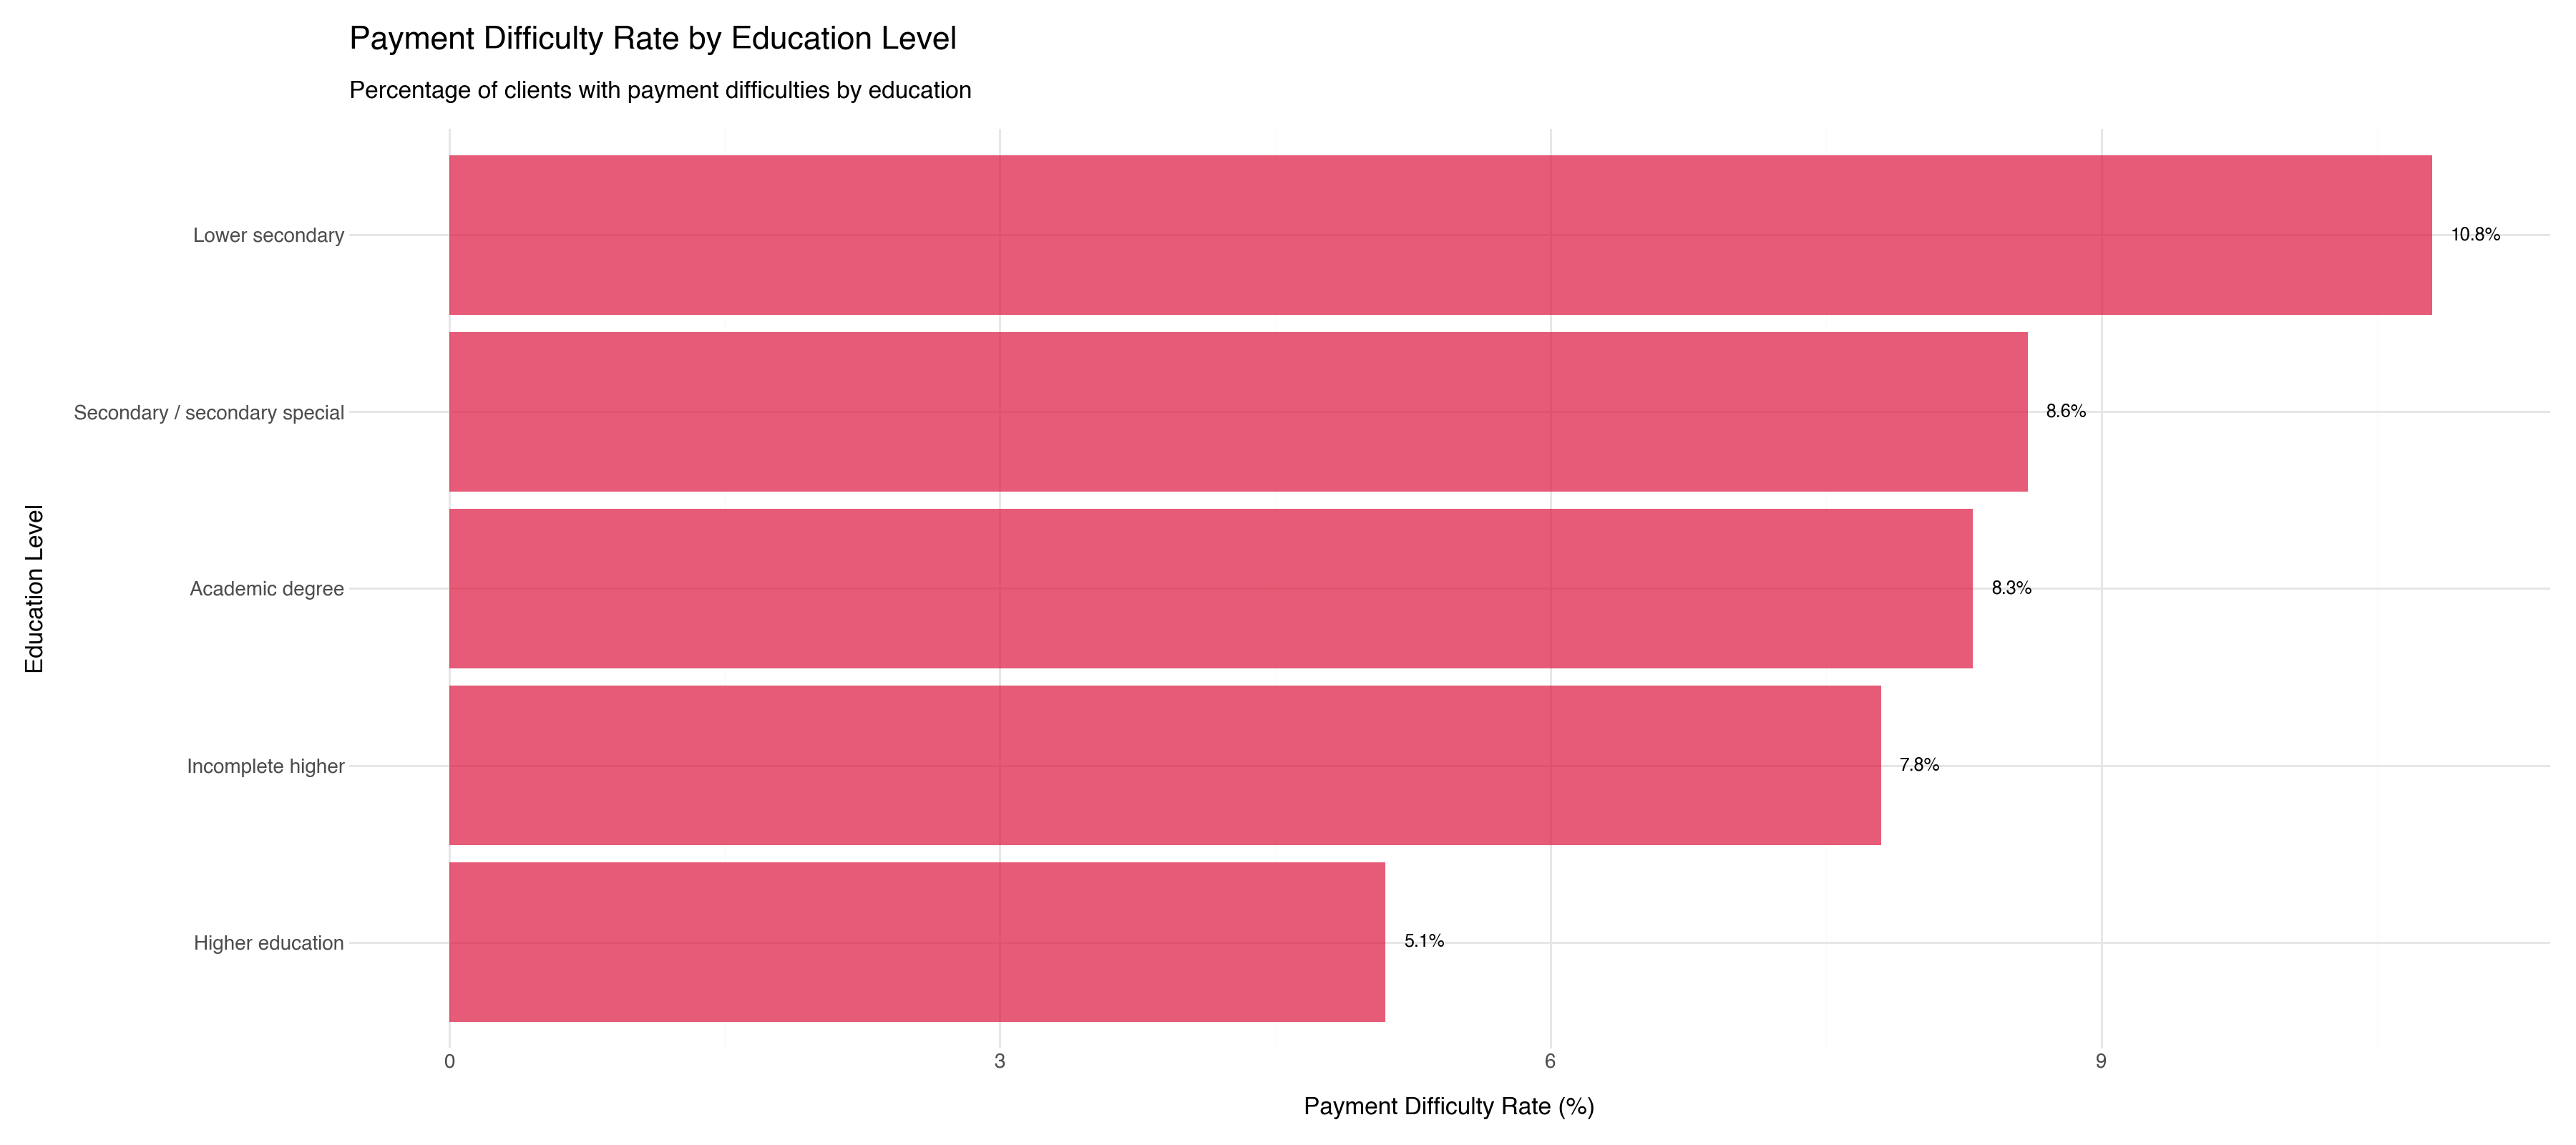

In [26]:
# Education vs target analysis using plotnine (FIXED)
education_target = (df[df['NAME_EDUCATION_TYPE'].notna()]
                   .groupby(['NAME_EDUCATION_TYPE', 'TARGET'])
                   .size()
                   .reset_index(name='count')
                   .pivot(index='NAME_EDUCATION_TYPE', columns='TARGET', values='count')
                   .fillna(0)
                   .assign(total=lambda x: x[0] + x[1])
                   .assign(percentage=lambda x: round(x[1] / x['total'] * 100, 1))
                   .reset_index()
                   .sort_values('percentage'))

# Add formatted labels (FIXED)
education_target['label_text'] = education_target['percentage'].astype(str) + '%'

plot = (ggplot(education_target, aes(x='reorder(NAME_EDUCATION_TYPE, percentage)', y='percentage')) +
        geom_col(fill='#DC143C', alpha=0.7) +
        geom_text(aes(label='label_text'), ha='left', nudge_y=0.1, size=9) +
        coord_flip() +
        labs(title='Payment Difficulty Rate by Education Level',
             subtitle='Percentage of clients with payment difficulties by education',
             x='Education Level',
             y='Payment Difficulty Rate (%)'))
plot

**Purpose**: This chart analyzes how education level correlates with payment difficulty rates to identify education-based risk patterns.

**Business Takeaway**: Higher education levels show lower default rates, suggesting education is a protective factor. This indicates potential for education-based pricing or approval criteria, and highlights opportunities for financial education programs for lower-educated segments.


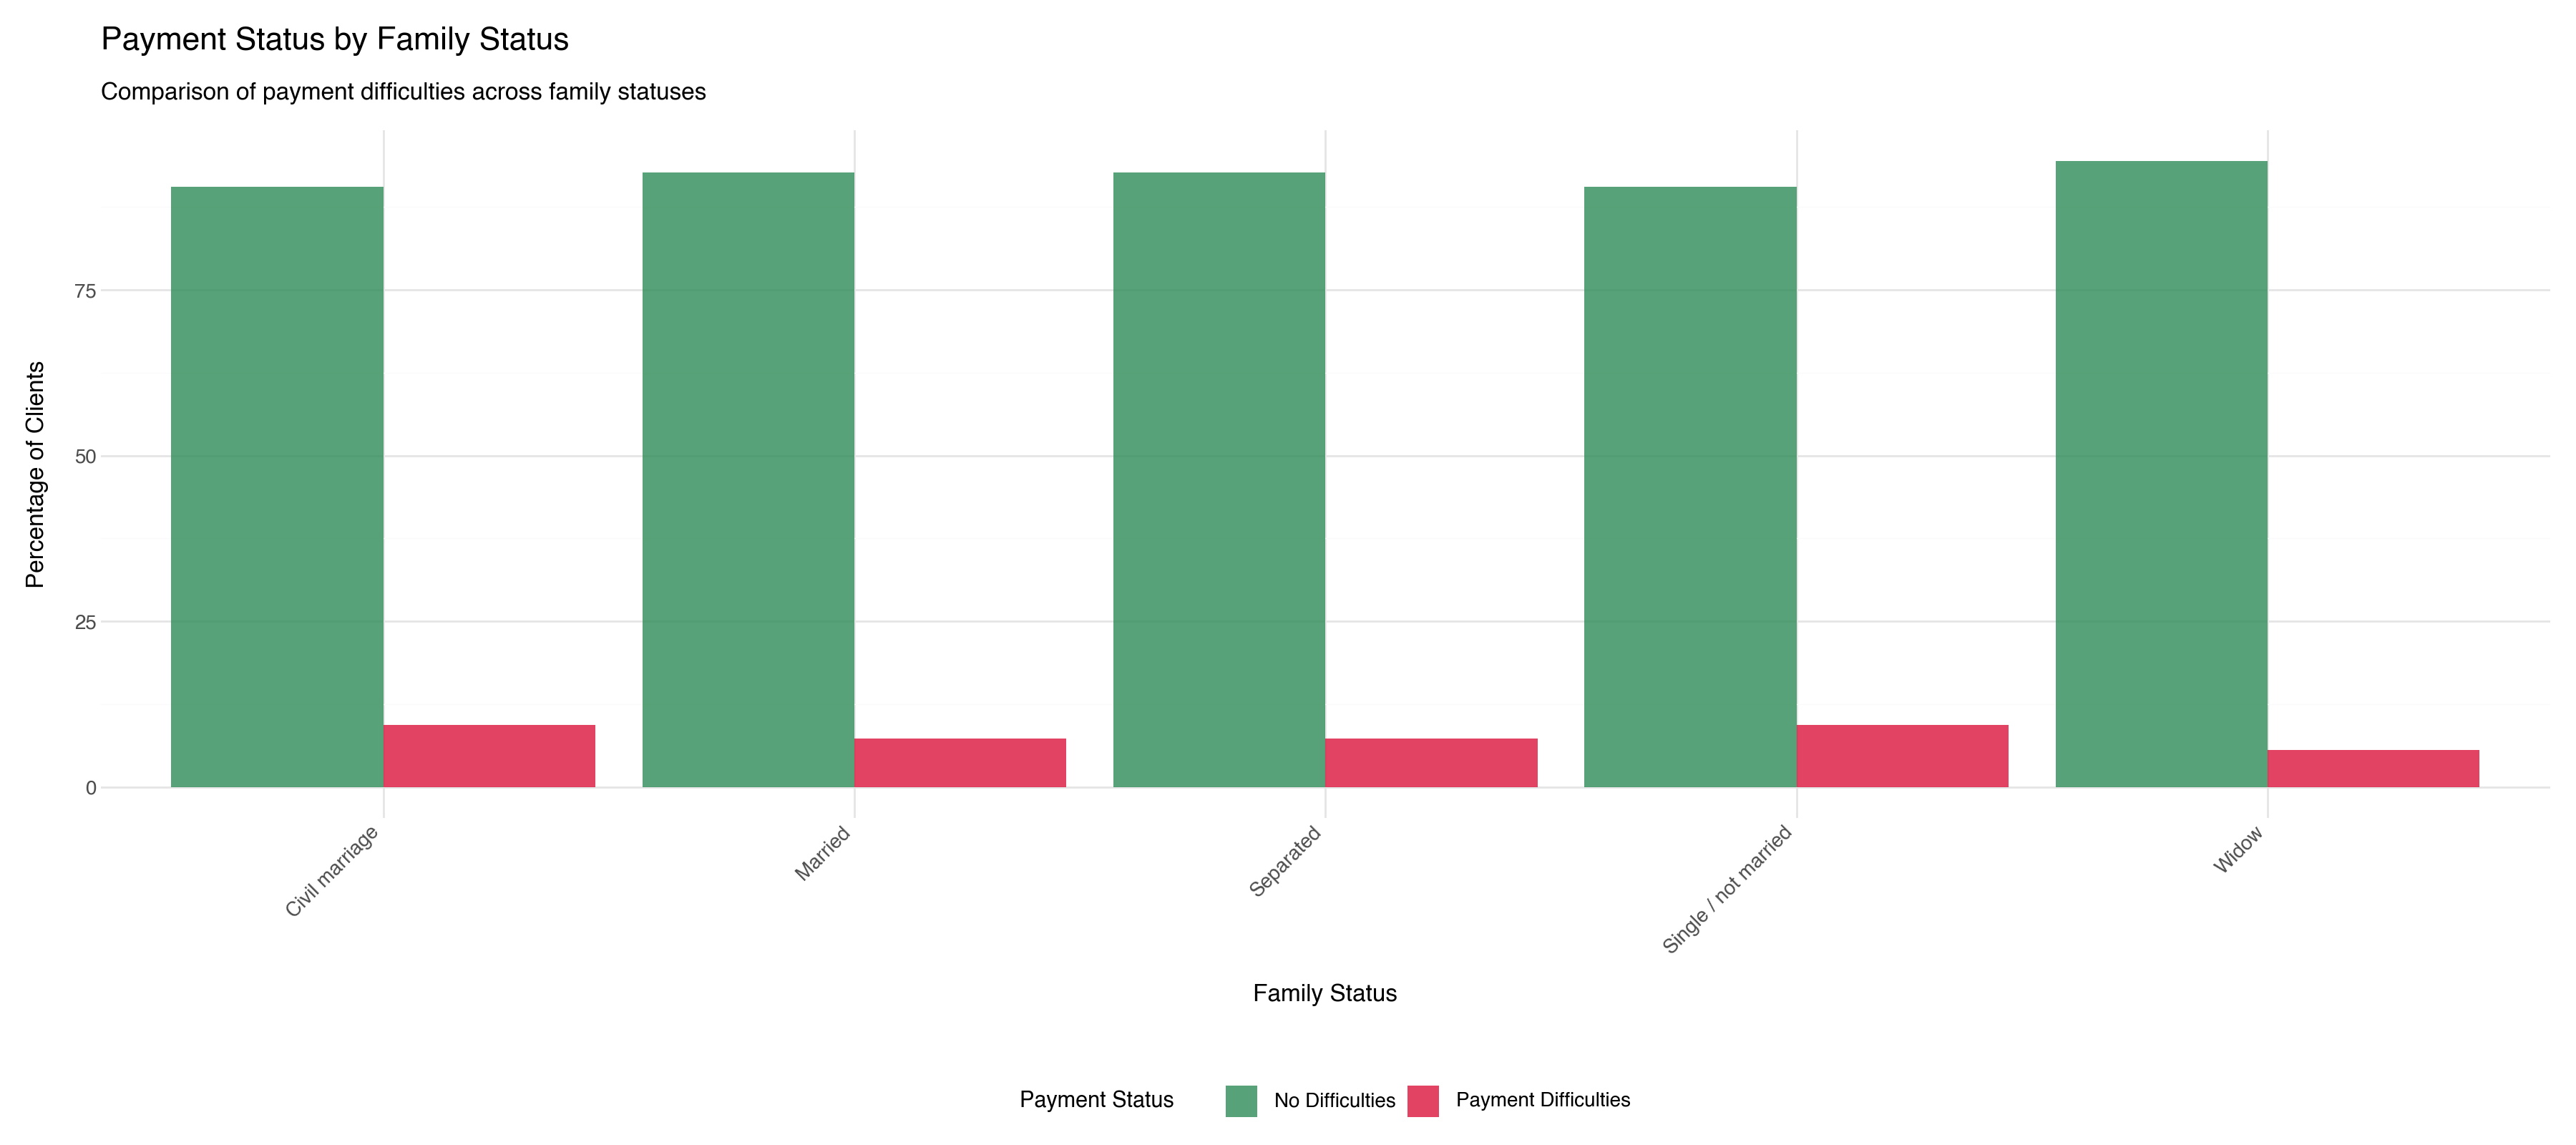

In [27]:
# Family status vs target analysis using plotnine (FIXED)
family_target = (df[df['NAME_FAMILY_STATUS'].notna()]
                .groupby(['NAME_FAMILY_STATUS', 'TARGET'])
                .size()
                .reset_index(name='count')
                .pivot(index='NAME_FAMILY_STATUS', columns='TARGET', values='count')
                .fillna(0)
                .assign(total=lambda x: x[0] + x[1])
                .assign(pct_0=lambda x: round(x[0] / x['total'] * 100, 1))
                .assign(pct_1=lambda x: round(x[1] / x['total'] * 100, 1))
                .reset_index()
                .melt(id_vars=['NAME_FAMILY_STATUS'], 
                      value_vars=['pct_0', 'pct_1'],
                      var_name='TARGET_TYPE', value_name='percentage')
                .assign(Target_Label=lambda x: x['TARGET_TYPE'].map({'pct_0': 'No Difficulties', 'pct_1': 'Payment Difficulties'})))

plot = (ggplot(family_target, aes(x='NAME_FAMILY_STATUS', y='percentage', fill='Target_Label')) +
        geom_col(position='dodge', alpha=0.8) +
        scale_fill_manual(values={'No Difficulties': '#2E8B57', 'Payment Difficulties': '#DC143C'}) +
        labs(title='Payment Status by Family Status',
             subtitle='Comparison of payment difficulties across family statuses',
             x='Family Status',
             y='Percentage of Clients',
             fill='Payment Status') +
        theme(axis_text_x=element_text(rotation=45, hjust=1)))

plot

**Purpose**: This grouped bar chart compares payment difficulty rates across different family statuses to understand relationship stability as a risk factor.

**Business Takeaway**: Married clients show lower default rates compared to single/divorced clients, suggesting relationship stability influences financial stability. This supports using family status as a risk assessment factor and potentially offering family-oriented financial products.
